## Auto reload

In [1]:
%reload_ext autoreload
%autoreload 2

## Imports and stuff

In [2]:

import math

import math
import os
from tempfile import TemporaryDirectory
from typing import Tuple
from collections import namedtuple,defaultdict,OrderedDict
import itertools

import torch
from torch.nn import Transformer
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset

import skimage.color as color
import numpy as np
import random

import utils
from utils import END_SYMBOL, START_SYMBOL, UNK_SYMBOL, PAD_SYMBOL

import color_processing as cp
np.set_printoptions(suppress=True)
torch.set_printoptions(sci_mode=False)


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Generate Toy data

In [3]:
color_wheel = 24
color_rep =    [ [np.cos( 2 * np.pi * i / color_wheel ),np.sin( 2 * np.pi * i / color_wheel )] for i in range(color_wheel) ]

def represent_color(rgb_c):
    lab = color.rgb2lab(np.asarray(rgb_c))
    lab[0] = lab[0] /100.0
    lab[1] = lab[1] /127.0
    lab[2] = lab[2] /127.0
    c  = [ np.dot( [lab[1],lab[2]], color_rep[i] ) for i in range(color_wheel) ]
    c.append( lab[0] )
    return np.array(c)

nocolors = 3
shuffle_idxs = list(itertools.permutations(list(range(nocolors)), nocolors)) 
reorder = lambda l,idx : [l[i] for i in idx]
# reorder = lambda l,idx : l #e.g. do not reorder

def get_unique_permutations(l,n=nocolors) :
    unique_perms = set()
    for perm in itertools.permutations(l,n):
        perm_set = frozenset(perm)
        if perm_set not in unique_perms:
            unique_perms.add(perm_set)
    return unique_perms

# l = get_unique_permutations([0,1,2,3])
# for i in l:
#     print(i)   



Toy    = namedtuple("Toy"  , "text discriminator comparator superlative complex colors idx")
Patch  = namedtuple("Patch", "text discriminator comparator superlative color idx")
PatchSet = namedtuple("PatchSet", "patches idx")

def create_color_embeddings( patches ) :
    c_embed = OrderedDict()
    embed_c = OrderedDict()
    for patch in patches :
        c_embed[patch.idx]  = represent_color(patch.color)
        embed_c[patch.text] = c_embed[patch.idx] 

    patch_sets = get_unique_permutations(list(range(len(patches))))
    patchsets  = []
    idx = 0
    for patch_set in patch_sets :
        indices  = [patches[i].idx for i in patch_set]
        patchset = PatchSet([patches[i] for i in patch_set],indices)
        patchsets.append(patchset)
    return c_embed, embed_c, patchsets

def create_toy_example(p,idx) :
    return Toy(p[0].text,
            f"{p[1].discriminator} {p[2].discriminator}",
            f"{p[0].comparator} than the others",
            f"the {p[0].superlative} one", 
            f"{p[0].comparator} than the {p[1].text} one {p[2].discriminator}",
            [p[0].color,p[1].color,p[2].color], idx )

patches = [

    # Patch("red"   ,"not red"   ,"redder"  ,"reddest" ,[1.0,0.0 ,0.0 ],0),
    # Patch("green" ,"not green" ,"greener" ,"greenest",[0.0,1.0 ,0.0 ],1),
    # Patch("blue"  ,"not blue"  ,"bluer"   ,"bluest"  ,[0.0,0.0 ,1.0 ],2),

    Patch("red"   ,"not red"   ,"redder"  ,"reddest" ,[1.0,0.0 ,0.0 ],0),
    Patch("orange","not orange","oranger" ,"orangest" ,[1.0,0.65,0.0 ],1),
    Patch("yellow","not yellow","yellower","yellowest",[1.0,1.0 ,0.0 ],2),
    Patch("green" ,"not green" ,"greener" ,"greenest",[0.0,1.0 ,0.0 ],3),
    Patch("blue"  ,"not blue"  ,"bluer"   ,"bluest"  ,[0.0,0.0 ,1.0 ],4),
    Patch("purple","not purple","purpler" ,"purplest",[.62,0.12,0.95],5),
    Patch("red1"   ,"not red"   ,"redder"  ,"reddest" ,[.9,0.0 ,0.0 ],6),
    Patch("red2"   ,"not red"   ,"redder"  ,"reddest" ,[.8,0.0 ,0.0 ],7),
    Patch("red3"   ,"not red"   ,"redder"  ,"reddest" ,[.7,0.0 ,0.0 ],8),
    Patch("green1" ,"not green" ,"greener" ,"greenest",[0.0,.9 ,0.0 ],9),
    Patch("green2" ,"not green" ,"greener" ,"greenest",[0.0,.8 ,0.0 ],10),
    Patch("green3" ,"not green" ,"greener" ,"greenest",[0.0,.7 ,0.0 ],11),
]

reps                 = [ lambda t : t.text ]#, lambda t : t.discriminator, lambda t : t.comparator, lambda t : t.superlative   , lambda t : t.complex ] 
templates            = [ create_toy_example ]
c_embed,embed_c,patch_sets   = create_color_embeddings(patches)

def create_toy_examples( patch_set , template )  :
    ps = patch_set.patches
    return [template( [ps[idx[0]],ps[idx[1]],ps[idx[2]]],reorder( patch_set.idx,idx) ) for idx in shuffle_idxs ]

def create_multiple_toy_examples( patch_sets, templates, reps ) :
    toy_list_list = [ create_toy_examples(patch_set,template) for template in templates for patch_set in patch_sets ]
    toys = [ toy for toy_list in toy_list_list for toy in toy_list  ]
    return  zip(*[[ toy.idx, toy.colors, rep(toy) ]  for toy in toys  for rep in reps ])

def create_data(c_embed, color_idx_list, text_list, min_count=2 ) :

    sentences = [  cp.tokenize_example( sentence )  for sentence in text_list  ]
    vocab     = utils.get_vocab(sentences,mincount=min_count)

    e = { word:len(c_embed)+k for k,word in enumerate(vocab) }
    word_dict = defaultdict(lambda : e[UNK_SYMBOL] )
    word_dict.update(e)

    sentences_idx_list  =  [ [ word_dict[word] for word in sentence ] for sentence in sentences ]



    ## This is how the data is organized - source sequence and then target sequence
    ## color_idx[0] is the correct color
    ## c_idx_reordered is the color + distractor colors in a random order
    ## sentence_idx is the color picker 
    def create_seq(shuffle_idx, color_idx, sentence_idx ) :
        c_idx_reordered =reorder(color_idx,shuffle_idx)
        return    [word_dict[START_SYMBOL]] + c_idx_reordered + sentence_idx + [word_dict[END_SYMBOL]] \
                + [word_dict[START_SYMBOL]] + [color_idx[0]] + [word_dict[END_SYMBOL]]  \
                + [word_dict[PAD_SYMBOL]] + [word_dict[PAD_SYMBOL]] + [word_dict[PAD_SYMBOL]]

    vocab = {v: k for k, v in word_dict.items()}
    vocab.update(c_embed)

    return word_dict, vocab, [create_seq(si,c,s) for c,s in zip(color_idx_list,sentences_idx_list) for si in  shuffle_idxs ]


toy_idx, toy_rgb_colors, toy_texts = create_multiple_toy_examples( patch_sets, templates , reps )

def create_train_data(c_embed, toy_idx, toy_texts, bptt, min_count=1) :
    word_dict, vocab , toy_data = create_data(c_embed, toy_idx, toy_texts, min_count=1 ) 
    data =  np.concatenate( toy_data ) 

    # print(target[0])
    print(f"vocab size: {len(vocab)}")
    print(f"example size: {len(toy_data)}")
    print(f"data word count: {data.shape}")
    # print(data.shape)
    # print(target.shape)

    return word_dict, vocab, toy_data, data

bptt       = 12  # sequence length source + sequence length target = 12
batch_size = 10

word_dict, vocab, toy_data, train_data =  create_train_data( c_embed, toy_idx, toy_texts, bptt, min_count=1 )
word_dict, vocab, toy_data, val_data   =  create_train_data( c_embed, toy_idx, toy_texts, bptt, min_count=1 )
word_dict, vocab, toy_data, test_data  =  create_train_data( c_embed, toy_idx, toy_texts, bptt, min_count=1 )

def get_batch(data,i : int, batch_size=batch_size,  seq_len=bptt ) :
    x = np.reshape(  np.copy(data[i:i+batch_size * seq_len ]) , (batch_size,seq_len) )
    x = x[:,0:seq_len // 2]
    return torch.from_numpy(x).view(batch_size, -1).t()

def get_labels(data,i : int, batch_size=batch_size,  seq_len=bptt ) :
    x = np.reshape(  np.copy(data[i:i+batch_size * seq_len ]) , (batch_size,seq_len) )
    x = x[:,seq_len // 2:]
    return torch.from_numpy(x).view(batch_size, -1).t()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

PAD_IDX = word_dict[PAD_SYMBOL]   
BOS_IDX = word_dict[START_SYMBOL]   
EOS_IDX = word_dict[END_SYMBOL]   


vocab size: 28
example size: 7920
data word count: (95040,)
vocab size: 28
example size: 7920
data word count: (95040,)
vocab size: 28
example size: 7920
data word count: (95040,)


## Look at toy data, make sure it looks right
#### shape is (seq_len, batch_size)

In [6]:
b = 0 # increment b += bptt * batch_size
print( get_batch( train_data, b) )
print( get_labels( train_data, b) )
print( get_batch( train_data, b).shape)


tensor([[15, 15, 15, 15, 15, 15, 15, 15, 15, 15],
        [ 1,  1,  2,  2,  9,  9,  1,  1,  9,  9],
        [ 2,  9,  1,  9,  1,  2,  9,  2,  1,  2],
        [ 9,  2,  9,  1,  2,  1,  2,  9,  2,  1],
        [21, 21, 21, 21, 21, 21, 21, 21, 21, 21],
        [13, 13, 13, 13, 13, 13, 13, 13, 13, 13]])
tensor([[15, 15, 15, 15, 15, 15, 15, 15, 15, 15],
        [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
        [13, 13, 13, 13, 13, 13, 13, 13, 13, 13],
        [14, 14, 14, 14, 14, 14, 14, 14, 14, 14],
        [14, 14, 14, 14, 14, 14, 14, 14, 14, 14],
        [14, 14, 14, 14, 14, 14, 14, 14, 14, 14]])
torch.Size([6, 10])


## Transformer code and classes

In [7]:


# helper Module that adds positional encoding to the token embedding to introduce a notion of word order.
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

# Seq2Seq Network
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

In [8]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

## Create Model

In [9]:
torch.manual_seed(0)

# may need to make them different vocabs, i doubt it though. 
SRC_VOCAB_SIZE = len(vocab)
TGT_VOCAB_SIZE = len(vocab)
EMB_SIZE = 64 #512 trains to 100% accuracy in 1 epoch
NHEAD = 8
FFN_HID_DIM = 32 #512 trains to 100% accuracy in 1 epoch
BATCH_SIZE = batch_size
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

## Test model output to make sure data is formatted correctly

In [10]:
src    = get_batch(train_data  , 0).to(DEVICE)
tgt    = get_labels(train_data  , 0).to(DEVICE)

tgt_input = tgt[:-1, :]

src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)
print(src.shape)
print(tgt_input.shape)

logits = transformer(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)
print(logits.shape)
print(len(vocab))

torch.Size([6, 10])
torch.Size([5, 10])
torch.Size([5, 10, 28])
28


## Train and Evaluate

In [11]:
from torch.utils.data import DataLoader

def train_epoch(model, optimizer):
    model.train()
    losses = 0
    num_batches = train_data.shape[0]

    for batch in range(0,train_data.shape[0] - bptt*batch_size,bptt*batch_size) :

        src    = get_batch(train_data  , batch).to(DEVICE)
        tgt    = get_labels(train_data  , batch).to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item() / train_data.shape[0]
        if (batch % 1000 == 0):
            print( f'{100.0*batch/num_batches:.2f}% done' )

    return losses 


def evaluate(model):
    model.eval()
    losses = 0

    for batch in range(0,train_data.shape[0] - (bptt)*batch_size , bptt*batch_size):

        src    = get_batch(val_data  , batch).to(DEVICE)
        tgt    = get_labels(val_data  , batch).to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses 

## Actually Train

In [12]:
from timeit import default_timer as timer
NUM_EPOCHS = 1

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer)
    end_time = timer()
    val_loss = evaluate(transformer)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))


# function to generate output sequence using greedy algorithm
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0)).type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()
        ys = torch.cat([ys,torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys



0.00% done
3.16% done
6.31% done
9.47% done
12.63% done
15.78% done
18.94% done
22.10% done
25.25% done
28.41% done
31.57% done
34.72% done
37.88% done
41.04% done
44.19% done
47.35% done
50.51% done
53.66% done
56.82% done
59.97% done
63.13% done
66.29% done
69.44% done
72.60% done
75.76% done
78.91% done
82.07% done
85.23% done
88.38% done
91.54% done
94.70% done
97.85% done
Epoch: 1, Train loss: 0.008, Val loss: 25.336, Epoch time = 13.946s


## Test the model on all the data for accuracy

In [13]:


def translate(model: torch.nn.Module, test_data):
    model.eval()

    batch_size = 1
    correct = 0
    total   = 0
    num_batches = test_data.shape[0] // batch_size

    for batch in range(0,test_data.shape[0] - (bptt)*batch_size , bptt*batch_size):
        src = get_batch(test_data  , batch, batch_size=1).to(DEVICE)
        lbl = get_labels(test_data , batch, batch_size=1).to(DEVICE)
    
        num_tokens = src.shape[0]
        src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
        tgt_tokens = greedy_decode(transformer,  src, src_mask, max_len=num_tokens, start_symbol=BOS_IDX).flatten()
                    
        correct += (tgt_tokens[1].eq(lbl[1])).item()  
        total += 1

        if (batch % 5000 ==0 ) :
            print(f"{100*batch/num_batches:.1f}% done | correct : {100*correct/total:.1f}%" )

        
    print(f"{num_batches/num_batches:.1f}% done | correct : {correct/total:.4f}%" )

translate(transformer, test_data)

0.0% done | correct : 100.0%
15.8% done | correct : 100.0%
31.6% done | correct : 99.7%
47.3% done | correct : 99.8%
63.1% done | correct : 99.8%
78.9% done | correct : 99.9%
94.7% done | correct : 99.9%
1.0% done | correct : 0.9990%


## Visualize Embeddings

vocab size: 28
cembed size: 12
trainable weights: (28, 64)
red 11
orange 9
yellow 15
green 5
blue 4
purple 10
red1 12
red2 13
red3 14
green1 6
green2 7
green3 8


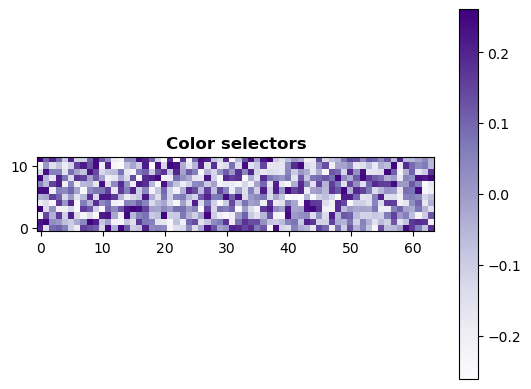

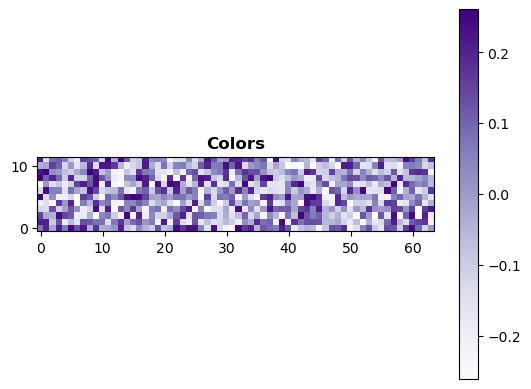

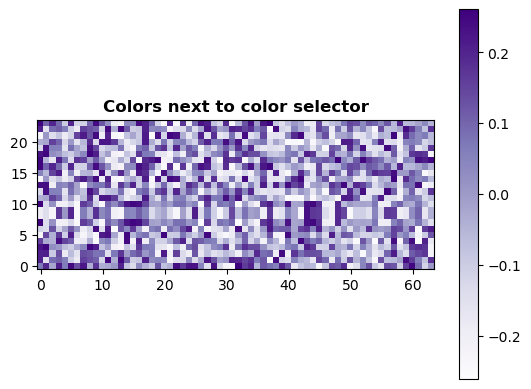

In [19]:
# Implementation of matplotlib function
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
from sklearn.preprocessing import normalize


weights = torch.clone( transformer.src_tok_emb.embedding.weight ).detach().numpy()
# weights   = normalize(weights, axis=1, norm='l1')


print(f"vocab size: {len(vocab)}")
print(f"cembed size: {len(c_embed)}")
print(f"trainable weights: {weights.shape}")

color_size = len(c_embed)

# for patch in patches :
#     print(patch.text, word_dict[patch.text],)

banded,trained,pretrained = [],[],[]
for patch in patches :
    print( patch.text , word_dict[ patch.text] - color_size )
    banded     =  banded     + [ weights[patch.idx,:] , weights[ word_dict[patch.text] - color_size ,: ] ]
    trained    =  trained    + [ weights[ word_dict[patch.text] - color_size ,: ] ]
    pretrained =  pretrained + [ weights[patch.idx,:] ]
banded = np.vstack(banded)
trained = np.vstack(trained)
pretrained = np.vstack(pretrained)
# print(vocab)


def visualize(weights,title) :      

    z = weights


    z_min, z_max = -np.abs(z).max(), np.abs(z).max()
    
    c = plt.imshow(z, cmap ='Purples', vmin = z_min, vmax = z_max,interpolation ='nearest', origin ='lower')
    #  extent =[x.min(), x.max(), y.min(), y.max()],
    plt.colorbar(c)
    
    plt.title(title, fontweight ="bold")
    plt.show()


visualize( trained, "Color selectors")
visualize( pretrained , "Colors")
visualize( banded, "Colors next to color selector" )
